In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold

In [ ]:
# 📌 Load Data
df = pd.read_csv("mci_features.csv")

In [5]:
df.head()

,Patient_ID,Modality,Window_Start,Window_End,Label,Timestamp_Mean,Timestamp_Std,Left Shoulder_Mean,Left Shoulder_Std,Right Shoulder_Mean,...,Left Knee_Jerk_Mean,Right Knee_Velocity_Mean,Right Knee_Acceleration_Mean,Right Knee_Jerk_Mean,Left Ankle_Velocity_Mean,Left Ankle_Acceleration_Mean,Left Ankle_Jerk_Mean,Right Ankle_Velocity_Mean,Right Ankle_Acceleration_Mean,Right Ankle_Jerk_Mean
0,1,Pose,0,30,Healthy,0.483387,0.288547,-0.754012,6.783806,0.754012,...,339.460262,28.860714,282.794635,-339.460262,18.345920,-341.004093,-215.785063,-18.345920,341.004093,215.785063
1,1,Pose,15,45,Healthy,0.983443,0.288547,1.415687,7.215773,-1.415687,...,-637.349895,-54.187116,-137.193998,637.349895,22.356888,333.972008,-262.962139,-22.356888,-333.972008,262.962139
2,1,Pose,30,60,Healthy,1.483498,0.288547,-1.535920,7.318624,1.535920,...,691.479560,58.789189,-60.877667,-691.479560,-54.509111,-199.209446,641.137201,54.509111,199.209446,-641.137201
3,1,Pose,45,75,Healthy,1.983554,0.288547,1.068728,6.959626,-1.068728,...,-481.146900,-40.906829,235.666143,481.146900,65.813854,-11.742487,-774.103808,-65.813854,11.742487,774.103808
4,1,Pose,60,90,Healthy,2.483609,0.288547,-0.192791,6.616778,0.192791,...,86.795456,7.379299,-320.322069,-86.795456,-51.947521,218.203405,611.007733,51.947521,-218.203405,-611.007733


In [ ]:
def plot_history(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy Plot
    axs[0].plot(history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[0].set_title(f"Model Accuracy - {title}")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Loss Plot
    axs[1].plot(history.history['loss'], label="Train Loss")
    axs[1].plot(history.history['val_loss'], label="Validation Loss")
    axs[1].set_title(f"Model Loss - {title}")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show()

In [6]:
df.columns

Index(['Patient_ID', 'Modality', 'Window_Start', 'Window_End', 'Label',
       'Timestamp_Mean', 'Timestamp_Std', 'Left Shoulder_Mean',
       'Left Shoulder_Std', 'Right Shoulder_Mean', 'Right Shoulder_Std',
       'Left Elbow_Mean', 'Left Elbow_Std', 'Right Elbow_Mean',
       'Right Elbow_Std', 'Left Wrist_Mean', 'Left Wrist_Std',
       'Right Wrist_Mean', 'Right Wrist_Std', 'Left Hip_Mean', 'Left Hip_Std',
       'Right Hip_Mean', 'Right Hip_Std', 'Left Knee_Mean', 'Left Knee_Std',
       'Right Knee_Mean', 'Right Knee_Std', 'Left Ankle_Mean',
       'Left Ankle_Std', 'Right Ankle_Mean', 'Right Ankle_Std',
       'Timestamp_Velocity_Mean', 'Timestamp_Acceleration_Mean',
       'Timestamp_Jerk_Mean', 'Left Shoulder_Velocity_Mean',
       'Left Shoulder_Acceleration_Mean', 'Left Shoulder_Jerk_Mean',
       'Right Shoulder_Velocity_Mean', 'Right Shoulder_Acceleration_Mean',
       'Right Shoulder_Jerk_Mean', 'Left Elbow_Velocity_Mean',
       'Left Elbow_Acceleration_Mean', 'Left Elb

In [ ]:
X = df.drop(columns=["Label","Patient_ID","Modality","Window_Start","Window_End","Timestamp_Mean","Timestamp_Std",'Timestamp_Velocity_Mean', 'Timestamp_Acceleration_Mean',
       'Timestamp_Jerk_Mean'])
y = df["Label"].map({"Healthy": 0, "MCI": 1})


In [8]:
X.head()

,Left Shoulder_Mean,Left Shoulder_Std,Right Shoulder_Mean,Right Shoulder_Std,Left Elbow_Mean,Left Elbow_Std,Right Elbow_Mean,Right Elbow_Std,Left Wrist_Mean,Left Wrist_Std,...,Left Knee_Jerk_Mean,Right Knee_Velocity_Mean,Right Knee_Acceleration_Mean,Right Knee_Jerk_Mean,Left Ankle_Velocity_Mean,Left Ankle_Acceleration_Mean,Left Ankle_Jerk_Mean,Right Ankle_Velocity_Mean,Right Ankle_Acceleration_Mean,Right Ankle_Jerk_Mean
0,-0.754012,6.783806,0.754012,6.783806,2.032756,9.546322,-2.032756,9.546322,2.007161,10.729716,...,339.460262,28.860714,282.794635,-339.460262,18.345920,-341.004093,-215.785063,-18.345920,341.004093,215.785063
1,1.415687,7.215773,-1.415687,7.215773,-1.668591,9.244159,1.668591,9.244159,-2.337592,11.007914,...,-637.349895,-54.187116,-137.193998,637.349895,22.356888,333.972008,-262.962139,-22.356888,-333.972008,262.962139
2,-1.535920,7.318624,1.535920,7.318624,0.666260,8.694620,-0.666260,8.694620,1.773991,10.555236,...,691.479560,58.789189,-60.877667,-691.479560,-54.509111,-199.209446,641.137201,54.509111,199.209446,-641.137201
3,1.068728,6.959626,-1.068728,6.959626,0.590889,8.671637,-0.590889,8.671637,-0.531911,9.967369,...,-481.146900,-40.906829,235.666143,481.146900,65.813854,-11.742487,-774.103808,-65.813854,11.742487,774.103808
4,-0.192791,6.616778,0.192791,6.616778,-1.622047,9.209197,1.622047,9.209197,-0.913603,10.083281,...,86.795456,7.379299,-320.322069,-86.795456,-51.947521,218.203405,611.007733,51.947521,-218.203405,-611.007733


In [14]:
y

0        0
1        0
2        0
3        0
4        0
        ..
71875    1
71876    1
71877    1
71878    1
71879    1
Name: Label, Length: 71880, dtype: int64

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA without specifying the number of components
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Step 4: Apply PCA to transform features while keeping the same count
pca = PCA(n_components=4)  # Keep 4 components (since you had 4 after dropping correlations)
X_pca = pca.fit_transform(X_scaled)

# 🔹 Step 5: Convert PCA-transformed features into a DataFrame
pca_feature_names = [f"PCA_Component_{i+1}" for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_feature_names)
df_pca["Label"] = y  # Reattach the labels

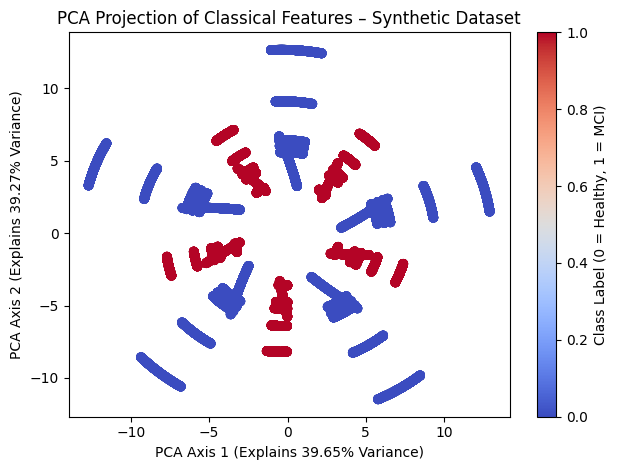

In [42]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm")
plt.xlabel("PCA Axis 1 (Explains {:.2f}% Variance)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PCA Axis 2 (Explains {:.2f}% Variance)".format(pca.explained_variance_ratio_[1] * 100))
plt.title("PCA Projection of Classical Features – Synthetic Dataset")
plt.colorbar(label="Class Label (0 = Healthy, 1 = MCI)")
plt.tight_layout()
plt.show()

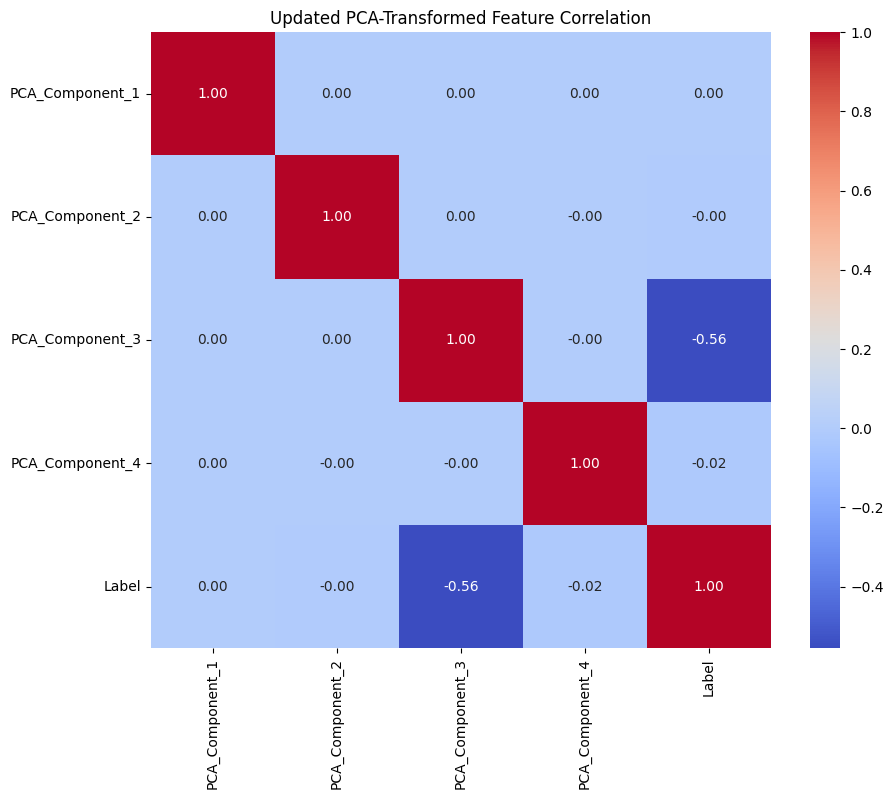

In [36]:
# Plot updated correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_pca.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Updated PCA-Transformed Feature Correlation")
plt.show()

In [37]:
def compute_class_variance(df, label_col="Label"):
    class_variances = df.groupby(label_col).var().mean(axis=1)
    return class_variances

# Compute variance per class for both
pca_variance = compute_class_variance(df_pca)

print("Class Variance in Classical PCA:", pca_variance)

Class Variance in Classical PCA: Label
0    19.437352
1     8.389119
dtype: float64


In [38]:
# ✅ Convert labels to one-hot encoding
num_classes = 2  # Adjust for your dataset
y_onehot = to_categorical(y, num_classes=num_classes)

# ✅ Split into Train/Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_onehot, test_size=0.2, random_state=42)

In [39]:
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [41]:
# Sequential model (LSTM)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, clipvalue=0.5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Train
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Epoch 1/30
1797/1797 [==============================] - 20s 10ms/step - loss: 0.3635 - accuracy: 0.8195 - val_loss: 0.0839 - val_accuracy: 0.9844
Epoch 2/30
1797/1797 [==============================] - 16s 9ms/step - loss: 0.0142 - accuracy: 0.9983 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 3/30
1797/1797 [==============================] - 19s 11ms/step - loss: 8.4321e-04 - accuracy: 1.0000 - val_loss: 3.7371e-04 - val_accuracy: 1.0000
Epoch 4/30
1797/1797 [==============================] - 19s 11ms/step - loss: 2.0763e-04 - accuracy: 1.0000 - val_loss: 1.0802e-04 - val_accuracy: 1.0000
Epoch 5/30
1797/1797 [==============================] - 20s 11ms/step - loss: 6.3725e-05 - accuracy: 1.0000 - val_loss: 3.5896e-05 - val_accuracy: 1.0000
Epoch 6/30
1797/1797 [==============================] - 18s 10ms/step - loss: 2.1120e-05 - accuracy: 1.0000 - val_loss: 1.2417e-05 - val_accuracy: 1.0000
Epoch 7/30
1797/1797 [==============================] - 16s 9ms/step - loss: 7.3190e-06 - acc

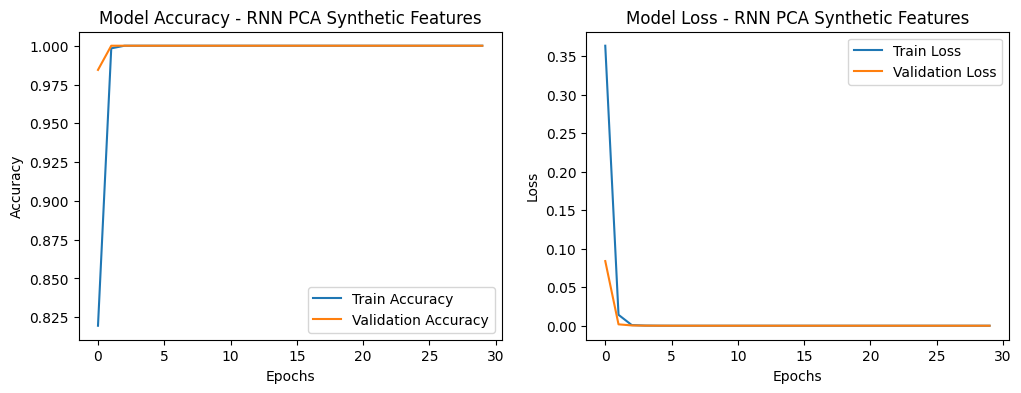

In [43]:
plot_history(history, "RNN PCA Synthetic Features")

450/450 [==============================] - 2s 3ms/step


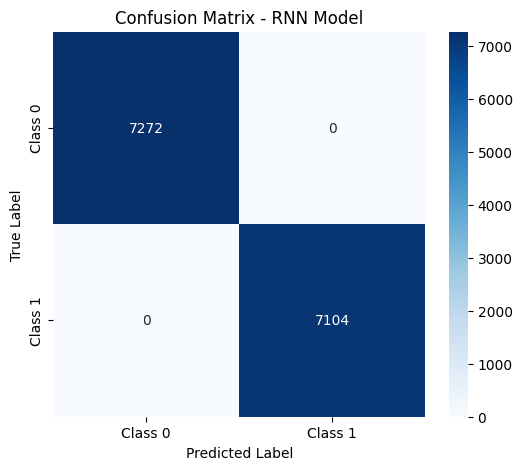

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7272
           1       1.00      1.00      1.00      7104

    accuracy                           1.00     14376
   macro avg       1.00      1.00      1.00     14376
weighted avg       1.00      1.00      1.00     14376



In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 🔹 Step 1: Get Model Predictions
y_pred_probs = model.predict(X_test)  # Get prediction probabilities


# 🔹 Step 2: Adjust Decision Threshold
threshold = 0.5
y_pred = (y_pred_probs[:, 0] > threshold).astype(int)

# 🔹 Step 3: Convert one-hot encoded labels (if needed)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check safely
    y_test = np.argmax(y_test, axis=1)  # Converts one-hot labels back to single-class


# 🔹 Step 4: Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 🔹 Step 5: Visualize Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - RNN Model")
plt.show()

# 🔹 Step 6: Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

In [45]:
# ✅ Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"DNN Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

450/450 [==============================] - 2s 4ms/step - loss: 9.8786e-10 - accuracy: 1.0000
DNN Test Accuracy: 1.0000 | Loss: 0.0000


In [46]:
# Get model predictions
y_pred_probs = model.predict(X_test)

# Check confidence distribution
print("Min Confidence:", np.min(y_pred_probs))
print("Max Confidence:", np.max(y_pred_probs))
print("Mean Confidence:", np.mean(y_pred_probs))

450/450 [==============================] - 1s 3ms/step
Min Confidence: 7.557267e-13
Max Confidence: 1.0
Mean Confidence: 0.49415693


450/450 [==============================] - 1s 3ms/step


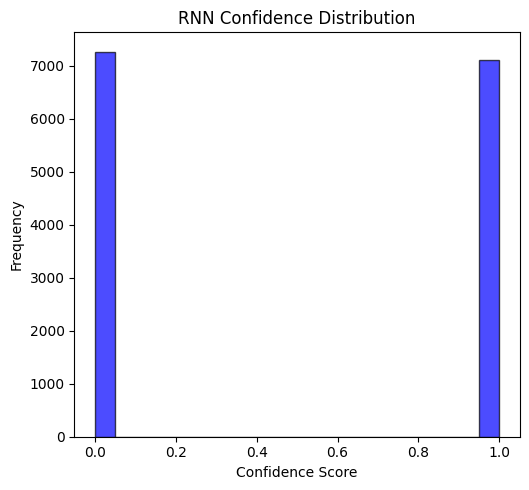

In [47]:
y_true_qnn = y_test  # Convert one-hot labels to class labels
y_pred_qnn = np.argmax(model.predict(X_test), axis=1)
confidences_qnn = np.max(model.predict(X_test), axis=1)

# Convert to numpy arrays if needed
qnn_confidences = np.array(confidences_qnn)  # Replace with your QNN confidence list

plt.figure(figsize=(10, 5))

# QNN Confidence Distribution
plt.subplot(1, 2, 1)
plt.hist(qnn_confidences, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("RNN Confidence Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [22]:
# Data Leak Check

In [48]:
from sklearn.utils import shuffle

X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)
leakage_model = tf.keras.models.clone_model(model)
leakage_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
leakage_model.fit(X_train_shuffled, y_train_shuffled, epochs=10, batch_size=64, verbose=1)
leakage_loss, leakage_acc = leakage_model.evaluate(X_test, y_test)

print(f'Leakage Test Accuracy: {leakage_acc:.4f} (should be ~0.50 for a valid test)')

Epoch 1/10
899/899 [==============================] - 12s 10ms/step - loss: 0.0000e+00 - accuracy: 0.4985
Epoch 2/10
899/899 [==============================] - 9s 10ms/step - loss: 0.0000e+00 - accuracy: 0.4985
Epoch 3/10
899/899 [==============================] - 8s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4985
Epoch 4/10
899/899 [==============================] - 9s 10ms/step - loss: 0.0000e+00 - accuracy: 0.4985
Epoch 5/10
899/899 [==============================] - 8s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4985
Epoch 6/10
899/899 [==============================] - 9s 10ms/step - loss: 0.0000e+00 - accuracy: 0.4985
Epoch 7/10
899/899 [==============================] - 8s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4985
Epoch 8/10
899/899 [==============================] - 8s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4985
Epoch 9/10
899/899 [==============================] - 9s 10ms/step - loss: 0.0000e+00 - accuracy: 0.4985
Epoch 10/10
450/450 [==============================] - 4s 

# K-Fold

In [ ]:
# Define number of folds
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Placeholder for epoch-wise averaging
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold+1}/{k}")

    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Define LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, clipvalue=0.5),
                loss="binary_crossentropy",
                metrics=["accuracy"])

    # Train model
    history = model.fit(X_train_fold, y_train_fold, 
                        epochs=20, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), 
                        verbose=1)

    # Store per-epoch results
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Evaluate model
    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")


Training Fold 1/5
Epoch 1/20
1438/1438 [==============================] - 23s 14ms/step - loss: 0.4320 - accuracy: 0.7778 - val_loss: 0.1915 - val_accuracy: 0.9058
Epoch 2/20
1438/1438 [==============================] - 18s 12ms/step - loss: 0.0855 - accuracy: 0.9625 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 3/20
1438/1438 [==============================] - 18s 12ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 7.2571e-04 - val_accuracy: 1.0000
Epoch 4/20
1438/1438 [==============================] - 17s 12ms/step - loss: 4.1060e-04 - accuracy: 1.0000 - val_loss: 2.2168e-04 - val_accuracy: 1.0000
Epoch 5/20
1438/1438 [==============================] - 18s 12ms/step - loss: 1.3917e-04 - accuracy: 1.0000 - val_loss: 8.2585e-05 - val_accuracy: 1.0000
Epoch 6/20
1438/1438 [==============================] - 18s 12ms/step - loss: 5.4332e-05 - accuracy: 1.0000 - val_loss: 3.3842e-05 - val_accuracy: 1.0000
Epoch 7/20
1438/1438 [==============================] - 18s 13ms/step - loss:


Final K-Fold Accuracy: 1.0000


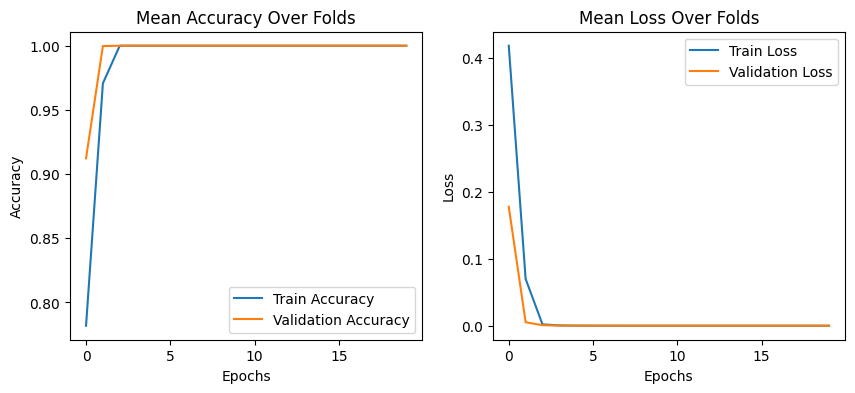

In [50]:
# Convert lists to NumPy arrays for easy averaging
train_accuracies = np.array(train_accuracies)
val_accuracies = np.array(val_accuracies)
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# Compute mean accuracy/loss across folds
mean_train_acc = np.mean(train_accuracies, axis=0)
mean_val_acc = np.mean(val_accuracies, axis=0)
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

# 🎯 Final mean accuracy across folds
final_accuracy = np.mean(val_accuracies[:, -1])
print(f"\nFinal K-Fold Accuracy: {final_accuracy:.4f}")

# 📊 Plot Accuracy Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(mean_train_acc, label='Train Accuracy')
plt.plot(mean_val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy Over Folds")
plt.legend()

# 📊 Plot Loss Curves
plt.subplot(1, 2, 2)
plt.plot(mean_train_loss, label='Train Loss')
plt.plot(mean_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Mean Loss Over Folds")
plt.legend()

plt.show()

In [ ]:
# Convert lists to numpy arrays
folds = list(range(1, len(train_accuracies) + 1))

# Create DataFrame with results per fold
df_results = pd.DataFrame({
    'Fold': folds,
    'Final Train Accuracy': [train_acc[-1] for train_acc in train_accuracies],
    'Final Validation Accuracy': [val_acc[-1] for val_acc in val_accuracies],
    'Final Train Loss': [train_loss[-1] for train_loss in train_losses],
    'Final Validation Loss': [val_loss[-1] for val_loss in val_losses]
})

# Print results
print("\n📊 K-Fold Cross-Validation Results:\n")
print(df_results)

# Compute summary statistics (mean & std deviation)
df_summary = df_results.describe().loc[['mean', 'std']]
print("\n📌 Summary Statistics (Mean & Std Deviation):\n")
print(df_summary)

# Save results to CSV
df_results.to_csv("kfold_results.csv", index=False)
df_summary.to_csv("kfold_summary.csv", index=False)

print("\n✅ Results saved as 'kfold_results.csv' and 'kfold_summary.csv'")


📊 K-Fold Cross-Validation Results:

   Fold  Final Train Accuracy  Final Validation Accuracy  Final Train Loss  \
0     1                   1.0                        1.0      5.002585e-09   
1     2                   1.0                        1.0      3.763267e-09   
2     3                   1.0                        1.0      5.616557e-09   
3     4                   1.0                        1.0      2.871570e-09   
4     5                   1.0                        1.0      4.414312e-09   

   Final Validation Loss  
0           4.452866e-09  
1           2.967735e-09  
2           5.041387e-09  
3           2.503450e-09  
4           3.973668e-09  

📌 Summary Statistics (Mean & Std Deviation):

          Fold  Final Train Accuracy  Final Validation Accuracy  \
mean  3.000000                   1.0                        1.0   
std   1.581139                   0.0                        0.0   

      Final Train Loss  Final Validation Loss  
mean      4.333658e-09           3.